# <div style="text-align:center; color:rgba(181, 174, 174);">11761 - Anàlisi d'Imatges i Video. Grup 1</div>
# <div style="text-align:center; color:rgba(181, 174, 174);">Master in Intelligent Systems</div>
# <div style="text-align:center; color:rgba(181, 174, 174);">Universitat de les Illes Balears</div>

### <div style="text-align:center; color:white;"> Project 2: **Step-by-step implementation of a visual tracking algorithm**</div>

#### **Integrants:** Pedro Marti Pico, Abdulrahman Alsatouf

## Recursos Adicionales
- [Presentation video](https://youtu.be/SLmCjY2ApuY)
- [Algorithm demo video](https://youtu.be/zxa8HiJWsMI)
- [Github repository](https://github.com/pedromartip/visual_tracking_algorithm)

> **Note 1:** There is a glitch in the upper right corner of the demo video where the image gets corrupted. There is a two-second span where erroneous bounding boxes appear.

> **Note 2:** You can find deeper explanation and faced challenges in the presentation video

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Display an image
def display_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

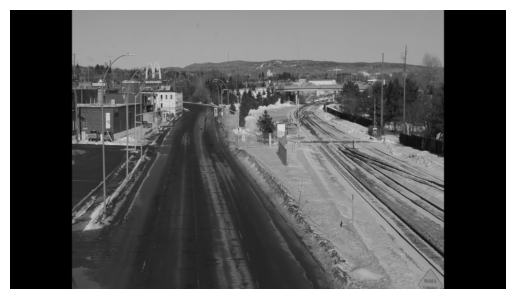

In [36]:
video_path = 'cars.mp4'
cap = cv2.VideoCapture(video_path)

# Check if the video can be opened
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

frame_sum = None
frame_number = 900

# Read and extract the frame
for i in range(frame_number):
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert frame to grayscale and accumulate it
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32)
    if frame_sum is None:
        frame_sum = gray_frame
    else:
        frame_sum += gray_frame

# Calculate and display the average background
averag_background = frame_sum / frame_number
averag_background = np.uint8(averag_background)
display_image(averag_background)


In [37]:
# Reset video to the first frame for processing
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Set up output video configuration
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_cars.avi', fourcc, fps, (width, height))

# Process each frame of the video
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale and calculate difference from background
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_delta = cv2.absdiff(gray_frame, averag_background)

    # Apply threshold to get binary image
    _, threshold = cv2.threshold(frame_delta, 30, 255, cv2.THRESH_BINARY)

    # Erode and dilate to reduce noise
    thresh_erode = cv2.erode(threshold, None, iterations=1) # Originally 1
    thresh_dilate = cv2.dilate(thresh_erode, None, iterations=3) # Originally 2

    # Detect contours and sort by their y position
    contours, _ = cv2.findContours(thresh_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1], reverse=True)  # Sort by y position

    filtered_boxes = [] # Store filtered bounding boxes

    # Filter and merge overlapping boxes
    for contour in contours:
        if cv2.contourArea(contour) > 200:
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = w / float(h)

            if 0.2 < aspect_ratio < 6:
                # Check if the current box overlaps with any previous box
                overlaps = False
                for prev_box in filtered_boxes:
                    prev_x, prev_y, prev_w, prev_h = prev_box

                    # Check for overlap
                    if (x < prev_x + prev_w and x + w > prev_x and y < prev_y + prev_h and y + h > prev_y):
                        overlaps = True

                        # Determine which box to keep. Prefer the lower (hence likely larger) box
                        if y > prev_y or (y == prev_y and h > prev_h):
                            filtered_boxes.remove(prev_box)
                            filtered_boxes.append((x, y, w, h))
                        break
                if not overlaps:
                    filtered_boxes.append((x, y, w, h))

    # Draw the filtered bounding boxes
    for x, y, w, h in filtered_boxes:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Count and display the number of cars in this frame
    contador_coches_frame = len(filtered_boxes)
    cv2.putText(frame, f'Cars: {contador_coches_frame}', 
                (10, 30),                   # Posición
                cv2.FONT_HERSHEY_SIMPLEX,   # Fuente
                1,                          # Tamaño de fuente
                (0, 255, 0),                # Color
                2)                          # Grosor

    # Display frames
    #display_image(gray_frame)
    #display_image(frame_delta)
    #display_image(threshold)
    #display_image(thresh_erode)
    #display_image(thresh_dilate)
    #display_image(frame)
    out.write(frame) # Write processed frame to output
    
# Release resources
cap.release()
out.release()